In [2]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import community as community_louvain
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from random import uniform

In [20]:
# --- Load POS tags with attributes ---
with open("pos_tags.json", "r", encoding="utf-8") as f:
    pos_tags = json.load(f)

def load_weighted_graph(file):
    G = nx.Graph()
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) != 3:
                continue
            node1, node2, weight = parts
            weight = int(weight)
            G.add_edge(node1, node2, weight=weight)
            for w in (node1, node2):
                if w in pos_tags:
                    G.nodes[w]['pos'] = pos_tags[w]['pos']
                    G.nodes[w]['gender'] = pos_tags[w]['gender']
                else:
                    G.nodes[w]["pos"] = None
                    G.nodes[w]["gender"] = None
    return G
G_male = load_weighted_graph("male_pairs_w.txt")
G_female = load_weighted_graph("female_pairs_w.txt")
G_mixed = load_weighted_graph("mixed_pairs_w.txt")


In [22]:
G_male.number_of_edges(),G_male.number_of_nodes(), G_female.number_of_edges(),G_female.number_of_nodes(), G_mixed.number_of_edges(),G_mixed.number_of_nodes()

(233363, 9974, 61274, 4670, 137146, 6776)

In [23]:
def top_20_by_degree_centrality(G, gender):
    degree_centrality = nx.degree_centrality(G)
    sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 20 nodes by degree centrality in {gender}-associated graph:")
    for node, centrality in sorted_nodes[:20]:
        print(f"Node: {node}, Degree Centrality: {centrality:.4f}")

In [24]:
top_20_by_degree_centrality(G_male, "male")
top_20_by_degree_centrality(G_female, "female")

Top 20 nodes by degree centrality in male-associated graph:
Node: take, Degree Centrality: 0.1708
Node: find, Degree Centrality: 0.1687
Node: return, Degree Centrality: 0.1369
Node: name, Degree Centrality: 0.1327
Node: give, Degree Centrality: 0.1310
Node: help, Degree Centrality: 0.1308
Node: leave, Degree Centrality: 0.1288
Node: go, Degree Centrality: 0.1260
Node: use, Degree Centrality: 0.1259
Node: friend, Degree Centrality: 0.1256
Node: back, Degree Centrality: 0.1252
Node: tell, Degree Centrality: 0.1228
Node: reveal, Degree Centrality: 0.1217
Node: make, Degree Centrality: 0.1176
Node: become, Degree Centrality: 0.1174
Node: get, Degree Centrality: 0.1129
Node: discover, Degree Centrality: 0.1124
Node: try, Degree Centrality: 0.1105
Node: father, Degree Centrality: 0.1096
Node: escape, Degree Centrality: 0.1052
Top 20 nodes by degree centrality in female-associated graph:
Node: find, Degree Centrality: 0.1366
Node: take, Degree Centrality: 0.1272
Node: jim, Degree Centrality: 

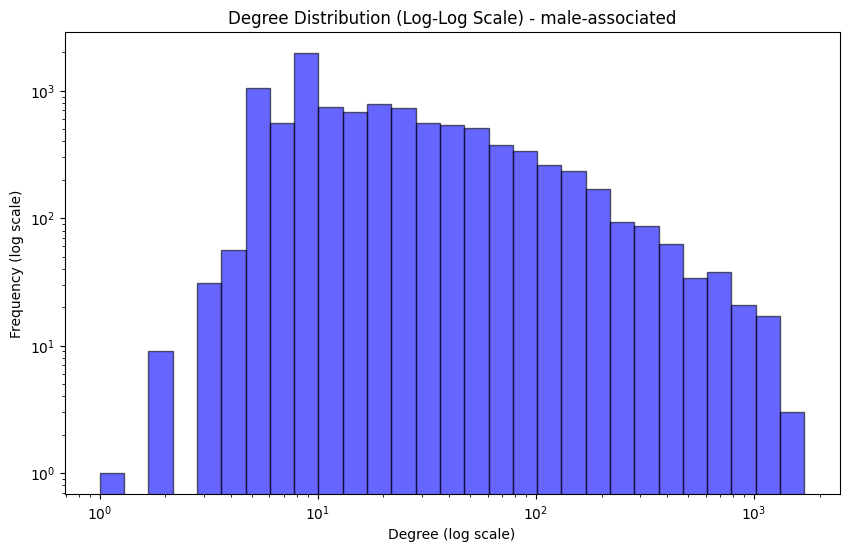

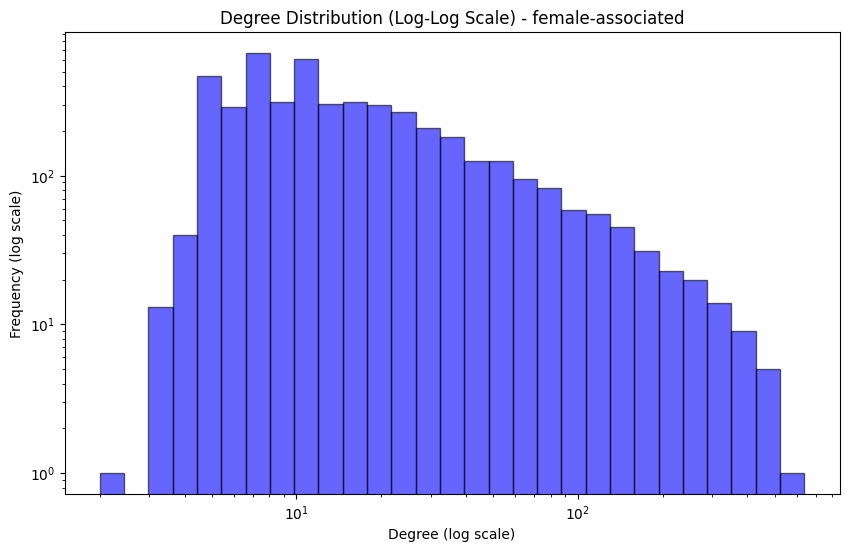

In [27]:
def plot_degree_dist_log(graph, gender=None):
    degrees = list(dict(graph.degree()).values())
    plt.figure(figsize=(10,6))
    plt.hist(degrees, bins=np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), 30), color='blue', alpha=0.6, edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Degree Distribution (Log-Log Scale)' + (f' - {gender}-associated' if gender else ''))    
    plt.show()
plot_degree_dist_log(G_male, "male")
plot_degree_dist_log(G_female, "female")

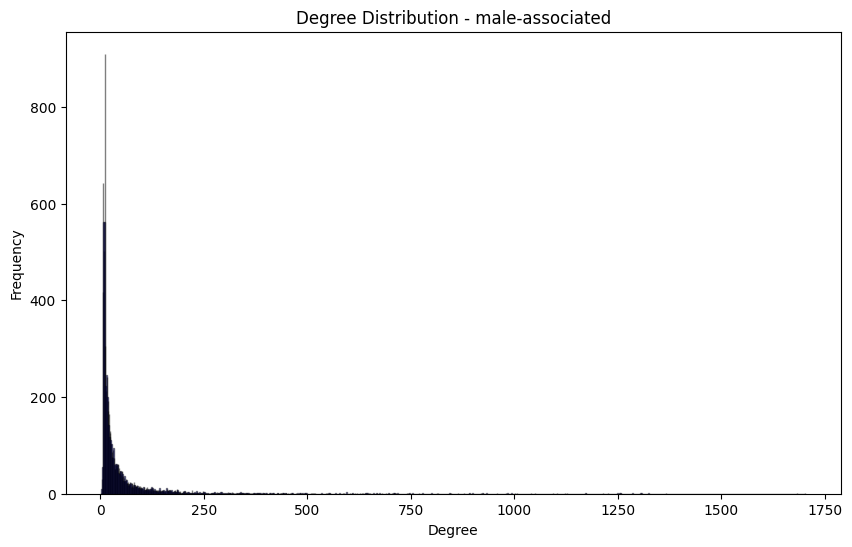

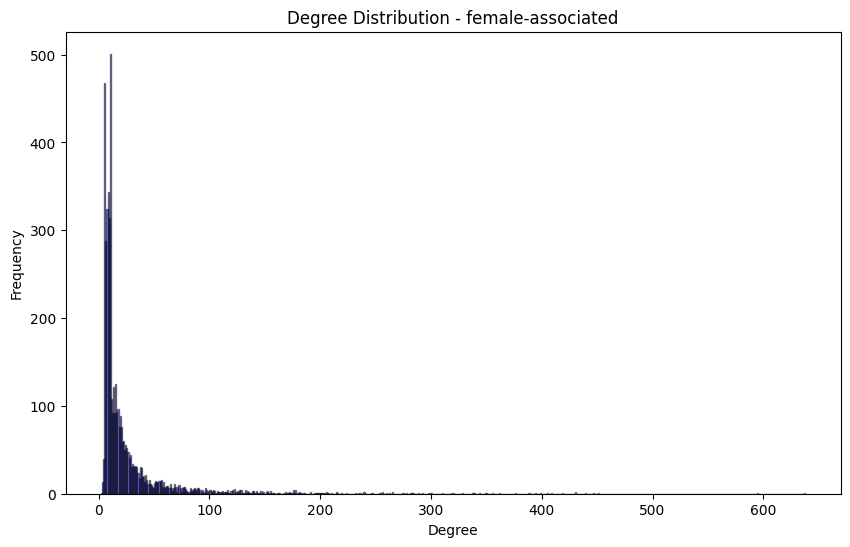

In [30]:
def plot_degree_dist(graph, gender):
    degree = dict(graph.degree())
    min_degree, max_degree = min(degree.values()), max(degree.values())
    degree_vector = np.arange(min_degree, max_degree + 1)
    degree_hist = np.histogram(list(degree.values()), bins=degree_vector)

    plt.figure(figsize=(10, 6))
    plt.hist(degree.values(), bins=degree_hist[1], color='blue', alpha=0.5, edgecolor='black')
    plt.title('Degree Distribution' + (f' - {gender}-associated' if gender else ''))
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
plot_degree_dist(G_male, "male")
plot_degree_dist(G_female, "female" )

In [31]:
sorted(G_male.degree(), key=lambda x: x[1], reverse=True)[:10], sorted(G_female.degree(), key=lambda x: x[1], reverse=True)[:10]

([('take', 1703),
  ('find', 1682),
  ('return', 1365),
  ('name', 1323),
  ('give', 1306),
  ('help', 1304),
  ('leave', 1285),
  ('go', 1257),
  ('use', 1256),
  ('friend', 1253)],
 [('find', 638),
  ('take', 594),
  ('jim', 451),
  ('return', 446),
  ('leave', 439),
  ('name', 430),
  ('give', 430),
  ('family', 418),
  ('reveal', 408),
  ('father', 405)])

In [32]:
def get_connected_component(graph):
    #get connected components
    connected_components = list(nx.connected_components(graph))
    print(f"Number of connected components: {len(connected_components)}")
    largest_cc = max(connected_components, key=len)
    G_largest = graph.subgraph(largest_cc)
    print(f"Largest connected component size: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")
    #num of genders in largest cc
    genders_in_largest_cc = [G_largest.nodes[node]["gender"] for node in G_largest.nodes() if G_largest.nodes[node]["gender"] is not None]
    dict_largest_cc = {}
    for gender in genders_in_largest_cc:
        if gender not in dict_largest_cc:
            dict_largest_cc[gender] = 1
        else:
            dict_largest_cc[gender] += 1 
    print(f'Gender distribution of graph')
    print(dict_largest_cc)
    return G_largest

m_largest = get_connected_component(G_male)
f_largest = get_connected_component(G_female)

Number of connected components: 2
Largest connected component size: 9971 nodes, 233360 edges
Gender distribution of graph
{'male': 2090, 'female': 44}
Number of connected components: 1
Largest connected component size: 4670 nodes, 61274 edges
Gender distribution of graph
{'female': 625, 'male': 107}


In [33]:
def get_info(graph, gender):
    person_nodes = [node for node in graph.nodes() if graph.nodes[node]["gender"] == gender] 
    adj = []
    verbs = []
    for node in person_nodes:
        for neighbor in graph.neighbors(node):
            if graph.nodes[neighbor]["pos"] == "ADJ":
                    adj.append(neighbor)
            if graph.nodes[neighbor]["pos"] == "VERB":
                    verbs.append(neighbor)
    return adj, verbs

male_adj, male_verbs = get_info(G_male, "male")
female_adj, female_verbs = get_info(G_female, "female")
mixed_m_adj, mixed_m_verbs = get_info(G_mixed, "male")
mixed_f_adj, mixed_f_verbs = get_info(G_mixed, "female")
mixed_adj = mixed_m_adj + mixed_f_adj
mixed_verbs = mixed_m_verbs + mixed_f_verbs

In [34]:
# male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(male_adj))
# female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(female_adj))
# mixed_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(mixed_adj))
# plt.figure(figsize=(20, 10))
# plt.subplot(3, 1, 1)
# plt.title("Male-associated Adjectives", size=20)
# plt.imshow(male_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.subplot(3, 1, 2)
# plt.title("Female-associated Adjectives", size=20)
# plt.imshow(female_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.subplot(3, 1, 3)
# plt.title("Mixed-associated Adjectives", size=20)
# plt.imshow(mixed_wordcloud, interpolation='bilinear')
# plt.axis('off') 
# plt.show()

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

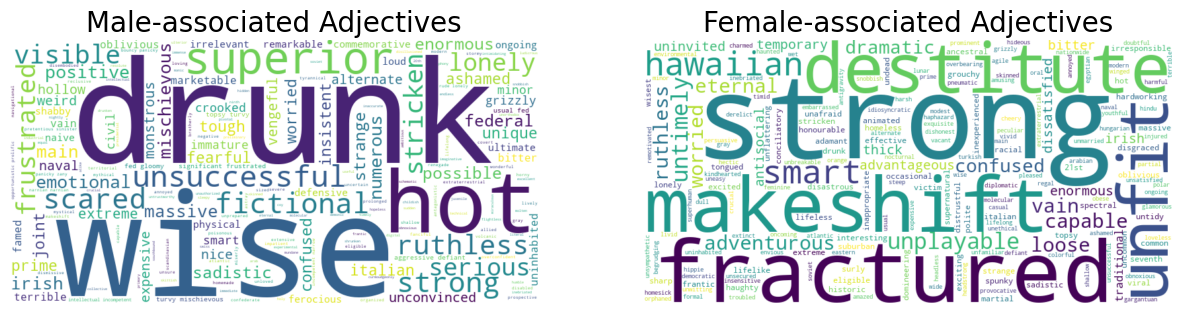

In [35]:
cleaned_male_adj = [adj for adj in male_adj if adj not in mixed_adj]
cleaned_female_adj = [adj for adj in female_adj if adj not in mixed_adj]    
male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_male_adj))
female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_female_adj))
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Male-associated Adjectives", size=20)
plt.imshow(male_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Female-associated Adjectives", size=20)
plt.imshow(female_wordcloud, interpolation='bilinear')
plt.axis('off')


In [36]:
# male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(male_verbs))
# female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(female_verbs))
# mixed_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(mixed_verbs))
# plt.figure(figsize=(15, 7))
# plt.subplot(1, 3, 1)
# plt.title("Male-associated Verbs", size=20)
# plt.imshow(male_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.subplot(1, 3, 2)
# plt.title("Female-associated Verbs", size=20)
# plt.imshow(female_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.subplot(1, 3, 3)
# plt.title("Mixed-associated Verbs", size=20)
# plt.imshow(mixed_wordcloud, interpolation='bilinear')
# plt.axis('off')

# plt.show()

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

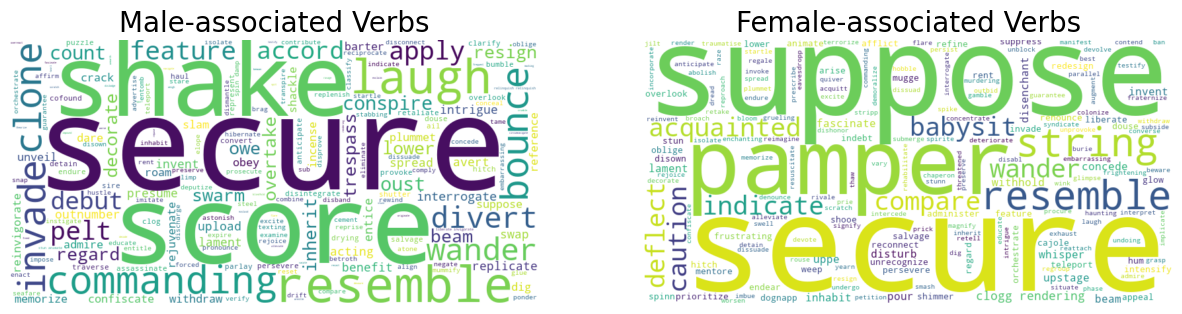

In [37]:
cleaned_male_verbs = [verb for verb in male_verbs if verb not in mixed_verbs]
cleaned_female_verbs = [verb for verb in female_verbs if verb not in mixed_verbs]    
male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_male_verbs))
female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_female_verbs))
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Male-associated Verbs", size=20)
plt.imshow(male_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Female-associated Verbs", size=20)
plt.imshow(female_wordcloud, interpolation='bilinear')
plt.axis('off')

In [38]:
#now we compute the log-odds ratio with dirichlet prior for adjectives
male_counts = Counter(male_adj)
female_counts = Counter(female_adj)

# Total adjectives for each gender
N_male = sum(male_counts.values())
N_female = sum(female_counts.values())

# Add a prior (Dirichlet smoothing)
alpha = 0.01  

scores = {}

all_adj = set(male_counts) | set(female_counts)

for adj in all_adj:
    c_m = male_counts[adj]
    c_f = female_counts[adj]

    p_m = (c_m + alpha) / (N_male + alpha * len(all_adj))
    p_f = (c_f + alpha) / (N_female + alpha * len(all_adj))

    # Log-odds score
    scores[adj] = np.log(p_m) - np.log(p_f)


In [39]:
male_top = sorted(scores.items(), key=lambda x: -x[1])[:20]
female_top = sorted(scores.items(), key=lambda x: x[1])[:20]
print("Top 20 male-associated adjectives:")
for adj, score in male_top:
    print(f"{adj}: {score:.4f}")
print("\nTop 20 female-associated adjectives:")
for adj, score in female_top:
    print(f"{adj}: {score:.4f}") 


Top 20 male-associated adjectives:
general: 6.3580
reluctant: 6.2354
favorite: 6.0957
rid: 5.8727
frustrated: 5.8727
comic: 5.8727
huge: 5.8082
superior: 5.7393
mischievous: 5.7393
african: 5.6652
scared: 5.6652
fictional: 5.6652
rightful: 5.5852
grumpy: 5.5852
tired: 5.5852
arctic: 5.5852
executive: 5.5852
warm: 5.5852
visible: 5.4983
newborn: 5.4983

Top 20 female-associated adjectives:
psychic: -7.9043
fractured: -7.7223
unplayable: -7.4996
hawaiian: -7.4996
pregnant: -7.4996
thick: -7.2128
uninvited: -7.2128
pompous: -7.2128
advantageous: -7.2128
pink: -7.2128
antisocial: -7.2128
dissatisfied: -7.2128
adventurous: -7.2128
petrified: -7.2128
lifelike: -6.8090
spunky: -6.8090
rambunctious: -6.8090
sixteenth: -6.8090
edwardian: -6.8090
conciliatory: -6.8090


In [40]:
def detect_communities(graph):
    """Detect communities in the graph using the Louvain method."""
    partition = community_louvain.best_partition(graph, weight='weight')

    num_communities = len(set(partition.values()))
    print(f"Number of communities detected: {num_communities}")

    partition_sizes = Counter(partition.values())
    largest_partitions = partition_sizes.most_common(4)
    top_community_ids = [comm_id for comm_id, size in largest_partitions]

    print("Sizes of the 4 largest communities:")
    print(sorted(largest_partitions, key=lambda x: x[1], reverse=True))

    return partition, top_community_ids  
m_communities, m_communities_ids = detect_communities(m_largest)
f_communities, f_communities_ids = detect_communities(f_largest)

Number of communities detected: 24
Sizes of the 4 largest communities:
[(0, 968), (12, 843), (2, 767), (3, 720)]
Number of communities detected: 20
Sizes of the 4 largest communities:
[(7, 543), (2, 445), (5, 425), (1, 345)]


In [41]:
#we assign the community as attribute to each node
for node, comm_id in m_communities.items():
    m_largest.nodes[node]['community'] = comm_id
for node, comm_id in f_communities.items():
    f_largest.nodes[node]['community'] = comm_id

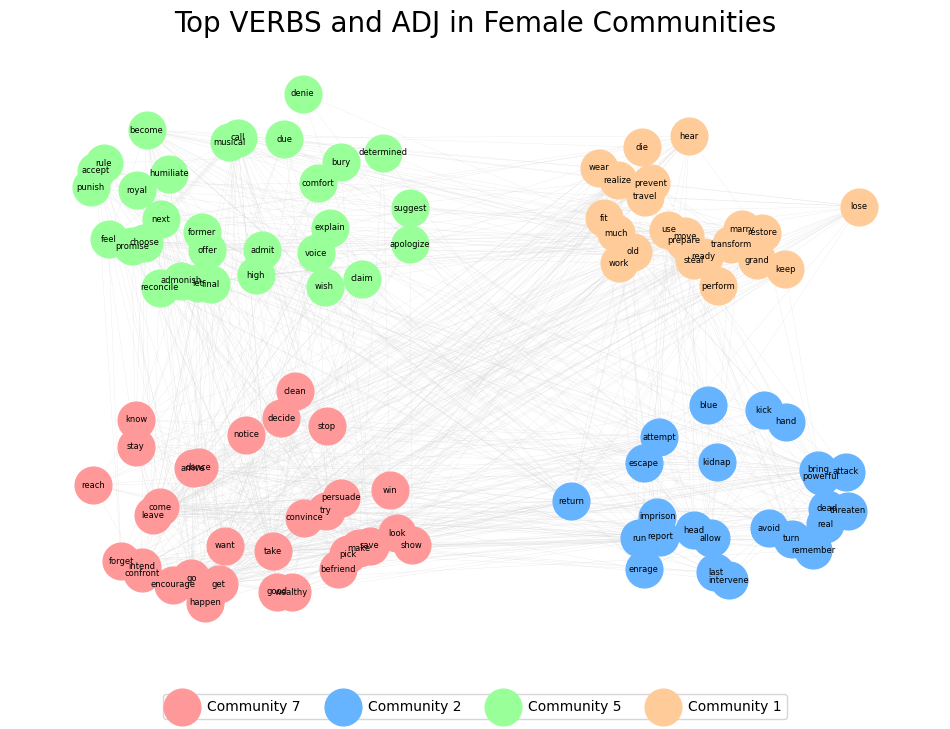

In [44]:
def plot_communities(graph, top_community_ids, title):
    #first, we filter the nodes to only include those in the top 4 communities and are VERB or ADJ
    top_nodes = [
        n for n, d in graph.nodes(data=True)
        if d.get('community') in top_community_ids and d.get('pos') in ['VERB', 'ADJ']
    ]
    G_filtered = graph.subgraph(top_nodes).copy()
    #then, we select the top 20% highest degree nodes from each community for visualization
    degrees = dict(G_filtered.degree())
    top_nodes_per_comm = []
    for comm_id in top_community_ids:
        nodes = [n for n, d in G_filtered.nodes(data=True) if d['community'] == comm_id]
        if not nodes:
            continue
        comm_degrees = {n: degrees[n] for n in nodes}
        threshold = np.percentile(list(comm_degrees.values()), 80)
        top_nodes_comm = [n for n, deg in comm_degrees.items() if deg >= threshold]
        top_nodes_per_comm.extend(top_nodes_comm)

    #then, we create a subgraph with only the top nodes
    G_top = G_filtered.subgraph(top_nodes_per_comm).copy()

    pos = {}
    grid_positions = [(0, 0), (1, 0), (0, 1), (1, 1)]
    grid_spacing = 10.0
    base_circle_radius = 2

    for i, comm_id in enumerate(top_community_ids):
        nodes = [n for n, d in G_top.nodes(data=True) if d['community'] == comm_id]
        if not nodes:
            continue
        #we scale radius by sqrt of number of nodes to give more space to larger communities
        circle_radius = base_circle_radius * np.sqrt(len(nodes)) /3.0  
        gx, gy = grid_positions[i]
        offset = np.array([gx * grid_spacing, gy * grid_spacing])
        
        for n in nodes:
            r = circle_radius * np.sqrt(uniform(0.1, 1)) 
            theta = uniform(0, 2*np.pi)
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            pos[n] = np.array([x, y]) + offset

    colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99"]
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_edges(G_top, pos, edge_color='lightgray', alpha=0.6, width=0.2)
    for i, comm_id in enumerate(top_community_ids):
        nodes = [n for n, d in G_top.nodes(data=True) if d['community'] == comm_id]
        if not nodes:
            continue
        nx.draw_networkx_nodes(
            G_top, pos,
            nodelist=nodes,
            node_color=colors[i],
            node_size=700,
            label=f"Community {comm_id}"
        )
    nx.draw_networkx_labels(G_top, pos,
                            labels={n: n for n in G_top.nodes()},
                            font_size=6,
                            font_color='black')

    plt.title(f"Top VERBS and ADJ in {title} Communities", size=20)

    plt.legend(
        fontsize=10, 
        loc='upper center',      
        bbox_to_anchor=(0.5, -0.05),
        ncol=4
    )
    plt.axis("off")
    plt.show()
    return G_top, top_nodes_per_comm

G_f_top, f_top_nodes = plot_communities(f_largest, f_communities_ids, "Female")

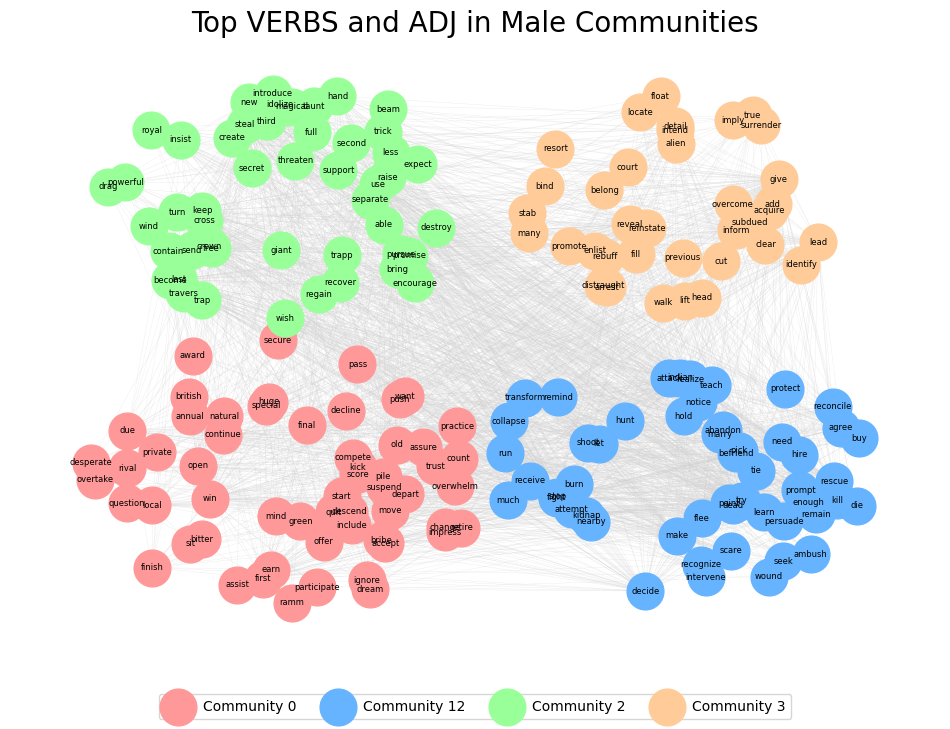

In [45]:
G_m_top, m_top_nodes = plot_communities(m_largest, m_communities_ids, "Male")

In [46]:
#we create a dict with the community and all the nodes from f_top_nodes
top_nodes_per_f_comm_dict = {}
for comm_id in f_communities_ids:
    nodes = [n for n, d in G_f_top.nodes(data=True) if d['community'] == comm_id]
    comm_nodes = [n for n in f_top_nodes if n in nodes]
    top_nodes_per_f_comm_dict[comm_id] = comm_nodes

In [47]:
#now we create a dict with the community and all the nodes from m_top_nodes
top_nodes_per_comm_m_dict = {}
for comm_id in m_communities_ids:
    nodes = [n for n, d in G_m_top.nodes(data=True) if d['community'] == comm_id]
    comm_nodes = [n for n in m_top_nodes if n in nodes]
    top_nodes_per_comm_m_dict[comm_id] = comm_nodes